In [ ]:
from torchvision import models 
from types import SimpleNamespace
import json, torch, torchvision, time, scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
 
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchsummary import summary
from google.colab import drive, files

In [ ]:
drive.mount ('/content/drive')      # Подключаем доступ к диску гугл и переводим процесс на графический контроллер
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cuda')

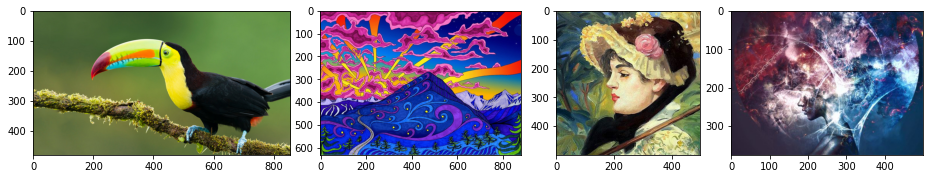

In [ ]:
way= '/content/drive/MyDrive/Colab Notebooks/II- 10 PyTorch. Часть 2/'
c=plt.subplot(1,4,3)
img_1= Image.open(way+ 'mane_famous.jpg')
img_1 = np.array(img_1)
plt.imshow(img_1)

b=plt.subplot(1,4,2)
img_2= Image.open(way+ 'Style.png')
img_2 = np.array(img_2)
plt.imshow(img_2)

a=plt.subplot(1,4,1)
img_3= Image.open(way+ 'tukan-ptica.jpg')
img_3 = np.array(img_3)
plt.imshow(img_3)

d=plt.subplot(1,4,4)
img_3= Image.open(way+ 'art_siurrealizm.jpg')
img_3 = np.array(img_3)
plt.imshow(img_3)

# координаты   - "У, Х"  и р-ры изобр.-"коэффициент"
a.set_position([0.0,0.0, 0.7, 0.5])
b.set_position([0.7,0.0, 0.5, 0.5])
c.set_position([1.18, 0.0, 0.5, 0.5]) 
d.set_position([1.64, 0.0, 0.5, 0.5])  
plt.show()

# Совмещение 2-x стилей изображения

In [ ]:
config = SimpleNamespace() 
config.content = way+'tukan-ptica.jpg'
config.style1 = way+'Style.png'
config.style2 = way+'mane_famous.jpg' 
config.style3 = way+'art_siurrealizm.jpg' 
config.maxSize = 350        # чтобы привести изображения к одному размеру
config.totalStep = 600      # общее количество шагов
config.step = 50            #  шаг
config.sampleStep = 100     # шаг для сохранения образца
config.lr = .003 

In [ ]:
class PretrainedNet(nn.Module):
    def __init__(self):
      super(PretrainedNet, self).__init__()
      self.select = [0,2,5,7,9,11,14]       # слои, через которые мы будем пропускать свое изображение
      self.pretrainedNet = models.vgg19(pretrained=True).to(device)       
    def forward(self, x):
      features = [] # Извлекаем из сетки карты признаков (feature map) со слоев с индексами, которые мы прописали выше 
      output = x
      for layerIndex in range(len(self.pretrainedNet.features)):   # Пробегаем по всем слоям блока features
        output = self.pretrainedNet.features[layerIndex](output)   # Прогоняем изображение через сетку вплоть до выбранного слоя 
        if layerIndex in self.select:                              # Если слой есть в списке слоев, то
          features.append(output)                                  # добавляем признаки в список
      return features                                              # Возвращаем собранные карты признаков

In [ ]:
def load_image(image_path, transform=None, maxSize=None, shape=None):
  image = Image.open(image_path)
  if maxSize:
    scale = maxSize / max(image.size)          # задаем масштаб для преобразования размера
    size = np.array(image.size) * scale        # масштабированный размер
    image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем    
  if shape:
    image = image.resize(shape, Image.LANCZOS)
  if transform:
    image = transform(image).unsqueeze(0)      # трансформировали + вытянули до батча
  return image.to(device)

# изменяем параметры mean & std

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize
                                (mean=(0.6, 0.5, 0.4),std=(0.3, 0.25, 0.2))])

In [ ]:
content = load_image(config.content, transform, maxSize=config.maxSize)
style1 = load_image(config.style3, transform, shape=[content.size(2), content.size(3)])
style2 = load_image(config.style1, transform, shape=[content.size(2), content.size(3)])

target = content.clone().requires_grad_(True)  # указываем, что элементы этого тензора изменяемые и по ним можно считать градиент
model = PretrainedNet().eval()                 # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()                 # функция ошибки

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
for step in range(config.totalStep):
# Для каждого из изображений извлекаем feature map
  targetFeatures= model.forward(target)                                                 # признаки для изменяемой
  contentFeatures= model.forward(content)                                               # признаки для исходной
  styleFeatures1= model.forward(style1)   
  styleFeatures2= model.forward(style2)
  styleFeatures= styleFeatures1+styleFeatures2                                          # признаки для стилей
  styleLoss= 0
  contentLoss= 0
# по каждому из трех изображений выбираем карты признаков, взятых с одного уровня
  for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
# Вычисляем потери для оригинала и конечной картинки
    contentLoss += contentCriteria(f1, f2)
# Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
    _, c, h, w = f1.size()                                                              # пропускаем batch
    f1= f1.reshape(c, h*w).to(device) 
    f3= f3.reshape(c, h*w).to(device)
# Находим матрицу Грама для конечной картинки и стиля
    f1= torch.mm(f1, f1.t()) 
    f3= torch.mm(f3, f3.t())
# Коэффициенты для того, чтобы увеличить/уменьшить вклад ошибки по стилю в общую ошибку
    kf1= 1 / (4 * (len(f1)*len(f3))**2)
    kf2= 1 / 4 * (len(f1)*len(f3))**2
    kf3= 1 / (c * w * h)
# Вычисляем потери для стиля и конечной картинки с выбранным коэффициентом
    styleLoss += contentCriteria(f1,f3) * kf2    
  loss= styleLoss + contentLoss                                             # Прописываем конечную функцию потерь 
  optimizer.zero_grad()                                                     # Обнуляем градиенты
  loss.backward()                                                           # Расчитываем градиент
  optimizer.step()                                                          # Шаг оптимизации

  if (step+1) % config.step == 0:
    print('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
          .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))
  if (step+1) % config.sampleStep == 0:                                                  # сохраняем картинку
    img= target.clone().squeeze() 
    img= img.clamp_(0, 1)                                                             # оставляем значения, в диапазоне 0-1
    torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [50/600], Ошибка для оригинала: 54.5492, Ошибка для стиля: 1.1700287630737408e+16
Шаг [100/600], Ошибка для оригинала: 56.3978, Ошибка для стиля: 3949811912933376.0
Шаг [150/600], Ошибка для оригинала: 57.3922, Ошибка для стиля: 2420338625347584.0
Шаг [200/600], Ошибка для оригинала: 57.7743, Ошибка для стиля: 2061511153418240.0
Шаг [250/600], Ошибка для оригинала: 58.7336, Ошибка для стиля: 2084528151592960.0
Шаг [300/600], Ошибка для оригинала: 58.4231, Ошибка для стиля: 1798417562992640.0
Шаг [350/600], Ошибка для оригинала: 58.9549, Ошибка для стиля: 1058173372858368.0
Шаг [400/600], Ошибка для оригинала: 58.9547, Ошибка для стиля: 955811148857344.0
Шаг [450/600], Ошибка для оригинала: 58.8651, Ошибка для стиля: 1157121500512256.0
Шаг [500/600], Ошибка для оригинала: 59.5037, Ошибка для стиля: 1806109983637504.0
Шаг [550/600], Ошибка для оригинала: 59.6713, Ошибка для стиля: 1456409719865344.0
Шаг [600/600], Ошибка для оригинала: 59.9402, Ошибка для стиля: 825381313576960.0


# Опыт наложения 1-го вар-та стиля
(mean=(0.6, 0.5, 0.4),std=(0.5, 0.3, 0.1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


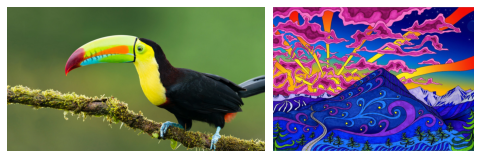

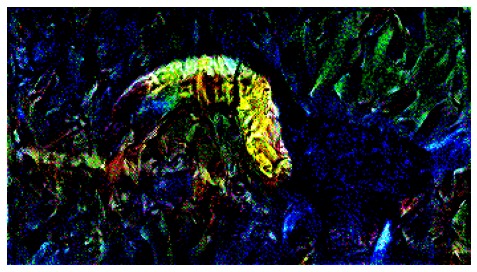

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,2,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,2,2)
style_img = Image.open(config.style1)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.6,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8.3,5))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()

# Опыт наложение 2-го вар-та стиля
(mean=(0.6, 0.5, 0.4),std=(0.5, 0.3, 0.1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


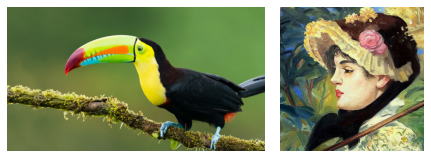

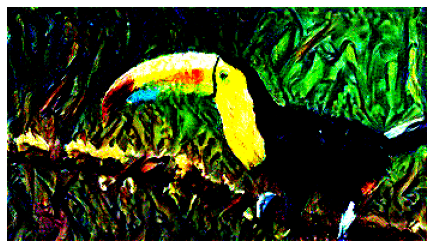

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,2,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,2,2)
style_img = Image.open(config.style1)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.55,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8,4.3))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()

# Опыт 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


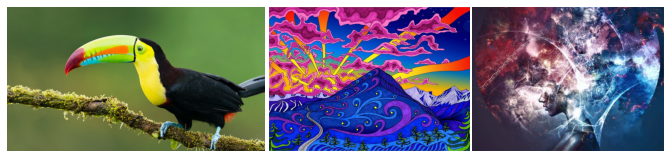

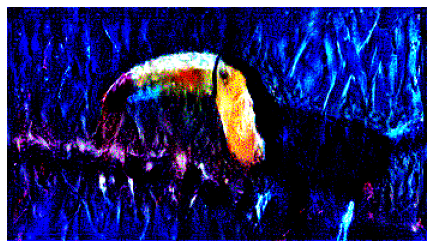

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,3,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,3,2)
style_img = Image.open(config.style1)
plt.imshow(style_img)
plt.axis('off')
c=plt.subplot(1,3,3)
style_img = Image.open(config.style3)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.59,0, 0.5, 0.5])
c.set_position([1.05,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8,4.3))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()

# Опыт 2
(mean=(0.6, 0.5, 0.4),std=(0.21, 0.22, 0.23))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


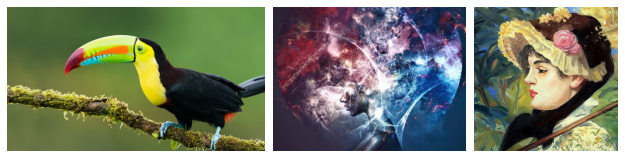

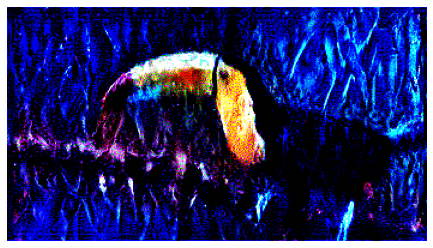

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,3,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,3,2)
style_img = Image.open(config.style3)
plt.imshow(style_img)
plt.axis('off')
c=plt.subplot(1,3,3)
style_img = Image.open(config.style2)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.59,0, 0.5, 0.5])
c.set_position([1,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8,4.3))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()

# Опыт 3
(mean=(0.7, 0.6, 0.5),std=(0.3, 0.25, 0.2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


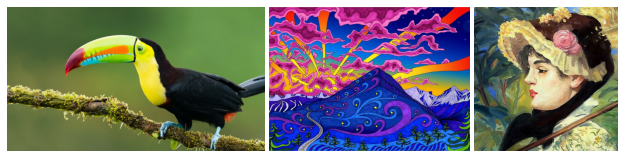

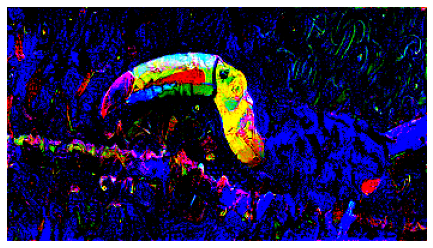

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,3,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,3,2)
style_img = Image.open(config.style1)
plt.imshow(style_img)
plt.axis('off')
c=plt.subplot(1,3,3)
style_img = Image.open(config.style2)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.59,0, 0.5, 0.5])
c.set_position([1,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8,4.3))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()

# Опыт 4
(mean=(0.4, 0.35, 0.3),std=(0.3, 0.25, 0.2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


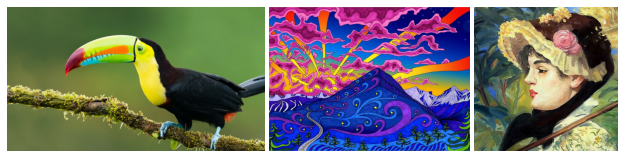

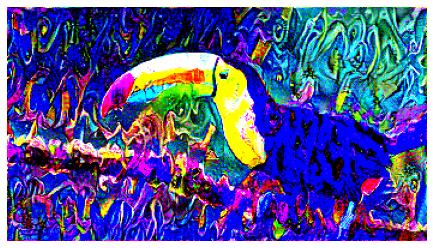

In [ ]:
# Выводим исходное изображение
a=plt.subplot(1,3,1)
content_img = Image.open(config.content)
plt.imshow(content_img)
plt.axis('off')
# Выводим изображение со стилем
b=plt.subplot(1,3,2)
style_img = Image.open(config.style1)
plt.imshow(style_img)
plt.axis('off')
c=plt.subplot(1,3,3)
style_img = Image.open(config.style2)
plt.imshow(style_img)
plt.axis('off')
a.set_position([0,0, 0.6, 0.5])
b.set_position([0.59,0, 0.5, 0.5])
c.set_position([1,0, 0.5, 0.5])
# Выводим изображение с перенесенным стилем
target_img = target.cpu().detach().numpy()[0].transpose(1,2,0)
plt.figure(figsize=(8,4.3))
#plt.subplot(2,1,1)
plt.imshow(target_img)
plt.axis('off')
plt.show()